# An Analysis of Rental Prices of Apartments in Texas
### Members:
    Mohammed Touseef Ansari
    Jerry Nguyen
    Cadence Parker
    Nadia Nafeesa Binti Rashid

### Introduction:
As first year students living on residence, we are fortunate to not think about our commute, cooking, and therefore be able to focus on the task at hands and that is studying. However, as our finals are approaching, we are faced with the imminent need to find housing. Therefore, we are inspired to assess the following dataset, taken from **UC Irvine Machine Leaning Repository**:https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified

This dataset contains 100,000 obersvations in 2019 of listed rentals, mainly apartments, across the US and the city it is located in. The following variables includes:
- `id = unique identifier of apartment`
- `category = category of classified`
- `title = title text of apartment`
- `body = body text of apartment`
- `amenities = like AC, basketball,cable, gym, internet access, pool, refrigerator etc`
- `bathrooms = number of bathrooms`
- `bedrooms = number of bedrooms`
- `currency = price in current`
- `fee = fee`
- `has_photo = photo of apartment`
- `pets_allowed = what pets are allowed dogs/cats etc.`
- `price = rental price of apartment`
- `price_display = price converted into display for reader`
- `price_type = price in USD`
- `square_feet = size of the apartment`
- `address =  where the apartment is located`
- `cityname =  where the apartment is located`
- `state =  where the apartment is located`
- `latitude = where the apartment is located`
- `longitude = where the apartment is located`
- `source = origin of classified`
- `time = when classified was created`

We will use this dataset to predict the average price of a rental based on their size and try to answer this question:
- **What are the monthly rental prices for a certain size of apartment in urban cities Texas? And how accurately does this correlation apply to the top 3 urban cities in Texas?**

The reason we would use Texas is because through our time exploring the data, we found that Texas has the highest count of rentals in the dataset.

In [19]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readr)

### Methods: Exploratory Data Analysis

In [20]:
# URL of the dataset
url <- "https://raw.githubusercontent.com/LightAwesome/apartment_rent_analysis/main/data/apartments_for_rent_classified_100K.csv"

# Read the dataset
apartments <- read_csv2(url)

# Display the first few rows of the dataset
head(apartments)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 98924 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (15): category, title, body, amenities, bathrooms, currency, fee, has_ph...
dbl  (5): id, bedrooms, price, square_feet, time
num  (2): latitude, longitude

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,⋯,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, Redondo Beach, 90277, CAMonthly rental rates range from $2195We have 1 beds units available for rent",null,1,1,USD,No,Thumbnail,⋯,"$2,195",Monthly,542,507 509 Esplanade,Redondo Beach,CA,338520,-1183759,RentLingo,1577360355
5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Newport News, 23602, VAMonthly rental rates range from $1250We have 3 beds units available for rent",null,1.5,3,USD,No,Thumbnail,⋯,"$1,250",Monthly,1500,146 Lochview Dr,Newport News,VA,370867,-764941,RentLingo,1577360340
5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,"This unit is located at 3101 Morningside Drive, Raleigh, 27607, NCMonthly rental rates range from $1395We have 3 beds units available for rent",null,2,3,USD,No,Thumbnail,⋯,"$1,395",Monthly,1650,3101 Morningside Dr,Raleigh,NC,358230,-786438,RentLingo,1577360332
5668639659,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacaville, 95687, CAMonthly rental rates range from $1600 - $1725We have 2 beds units available for rent",null,1,2,USD,No,Thumbnail,⋯,"$1,600",Monthly,820,209 Aegean Way,Vacaville,CA,383622,-1219712,RentLingo,1577360330
5668639374,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Albuquerque, 87108, NMMonthly rental rates range from $975 - $1100We have one - two beds units available for rent",null,1,1,USD,No,Thumbnail,⋯,$975,Monthly,624,4805 Marquette NE,Albuquerque,NM,351038,-1066110,RentLingo,1577360308
5668639368,housing/rent/apartment,Two BR 7801 Marble NE,"This unit is located at 7801 Marble NE, Albuquerque, 87110, NMMonthly rental rates range from $1250 - $1300We have 2 beds units available for rent",null,1.5,2,USD,No,Thumbnail,⋯,"$1,250",Monthly,965,7801 Marble NE,Albuquerque,NM,351038,-1066110,RentLingo,1577360308


_Figure 1: Our raw dataset - without cleaning or filtering out unnecessary variable_

In [21]:
#The following code is used to isolate for the rental that is classified as "Monthly".
#We also filtered out for unnecessary variables like amenities, price_type, currency, time, etc...that does not contribute to our analysis.
apt_wrangled <- apartments |>
                filter(bathrooms != 'null')|>
                filter(bedrooms != 'null')|>
                filter(price_type == "Monthly")|>
                mutate(bathrooms = as.numeric(bathrooms))|>
                mutate(bedrooms = as.numeric(bedrooms))|>
                mutate(category = as.factor(category))|>
                mutate(category = fct_recode(category,
                                            'Apartment' = 'housing/rent/apartment',
                                            'Home' = 'housing/rent/home',
                                            'Short Term' = 'housing/rent/short_term'))|>
                # mutate(time = as.POSIXct(time, origin="1970-01-01"))|>
                select(-amenities, - price_type, -currency, -time, -source,  -latitude,- longitude, -pets_allowed, -price_display, 
                       -address, -title, -body, -fee, -has_photo, -id)
#We also filter out "null" values - for bedroom and bathrooms.
   
head(apt_wrangled)


category,bathrooms,bedrooms,price,square_feet,cityname,state
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Apartment,1.0,1,2195,542,Redondo Beach,CA
Apartment,1.5,3,1250,1500,Newport News,VA
Apartment,2.0,3,1395,1650,Raleigh,NC
Apartment,1.0,2,1600,820,Vacaville,CA
Apartment,1.0,1,975,624,Albuquerque,NM
Apartment,1.5,2,1250,965,Albuquerque,NM


_Figure 2: The first 6 rows of the cleaned data fram that filtered out most unnecessary information_

In [22]:
#This line of code is part of our exploratory data analysis - where we group the apartments by state and see which one has the highest count of monthly rentals.
apt_top_state <-  apt_wrangled |>
            group_by (state)|>
            summarize(count = n())|>
            arrange(desc(count))|>
            slice(0:1)
apt_top_state

state,count
<chr>,<int>
TX,11188


_Figure 3: The state with the highest count of monthly rentals_

In [23]:
#As for this line of code below, it is use to generate the top 3 cities with the highest count within the chosen state form the previous code.
apt_texas_topcities <- apt_wrangled |>
                    filter(state %in% apt_top_state)|>
                    group_by(state, cityname)|>
                    summarize(count = n())|>
                    arrange(desc(count)) |>
                    slice(0:3)
apt_texas_topcities


`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.


state,cityname,count
<chr>,<chr>,<int>
TX,Dallas,2798
TX,San Antonio,873
TX,Houston,739


_Figure 4: This table shows the top 3 cities (all urban cities) in Texas with the highest count of rental_

In [24]:
#As we can see from the above line of code - we now know that Texas has to highest count of properties and and found its 3 corresponding cities
#This line of code is use to pull the 3 city name we found from the tibble apt_texas_topcities and then select only the state Texas from our apt_wrangled data in order to create a tibble of our 3 urban cities in Texas.
apt_texas_cities <- apt_wrangled |>
                    filter(cityname %in% pull(apt_texas_topcities,cityname) & state == "TX")

head(apt_texas_cities)
                

category,bathrooms,bedrooms,price,square_feet,cityname,state
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Apartment,1,1,729,800,San Antonio,TX
Apartment,1,1,975,615,San Antonio,TX
Apartment,1,1,975,650,San Antonio,TX
Apartment,1,1,945,530,San Antonio,TX
Apartment,1,1,665,443,Houston,TX
Apartment,1,1,975,882,San Antonio,TX


_Figure 5: The same dataset from figure 2 - however is filtered only for the state Texas and its top 3 urban cities_

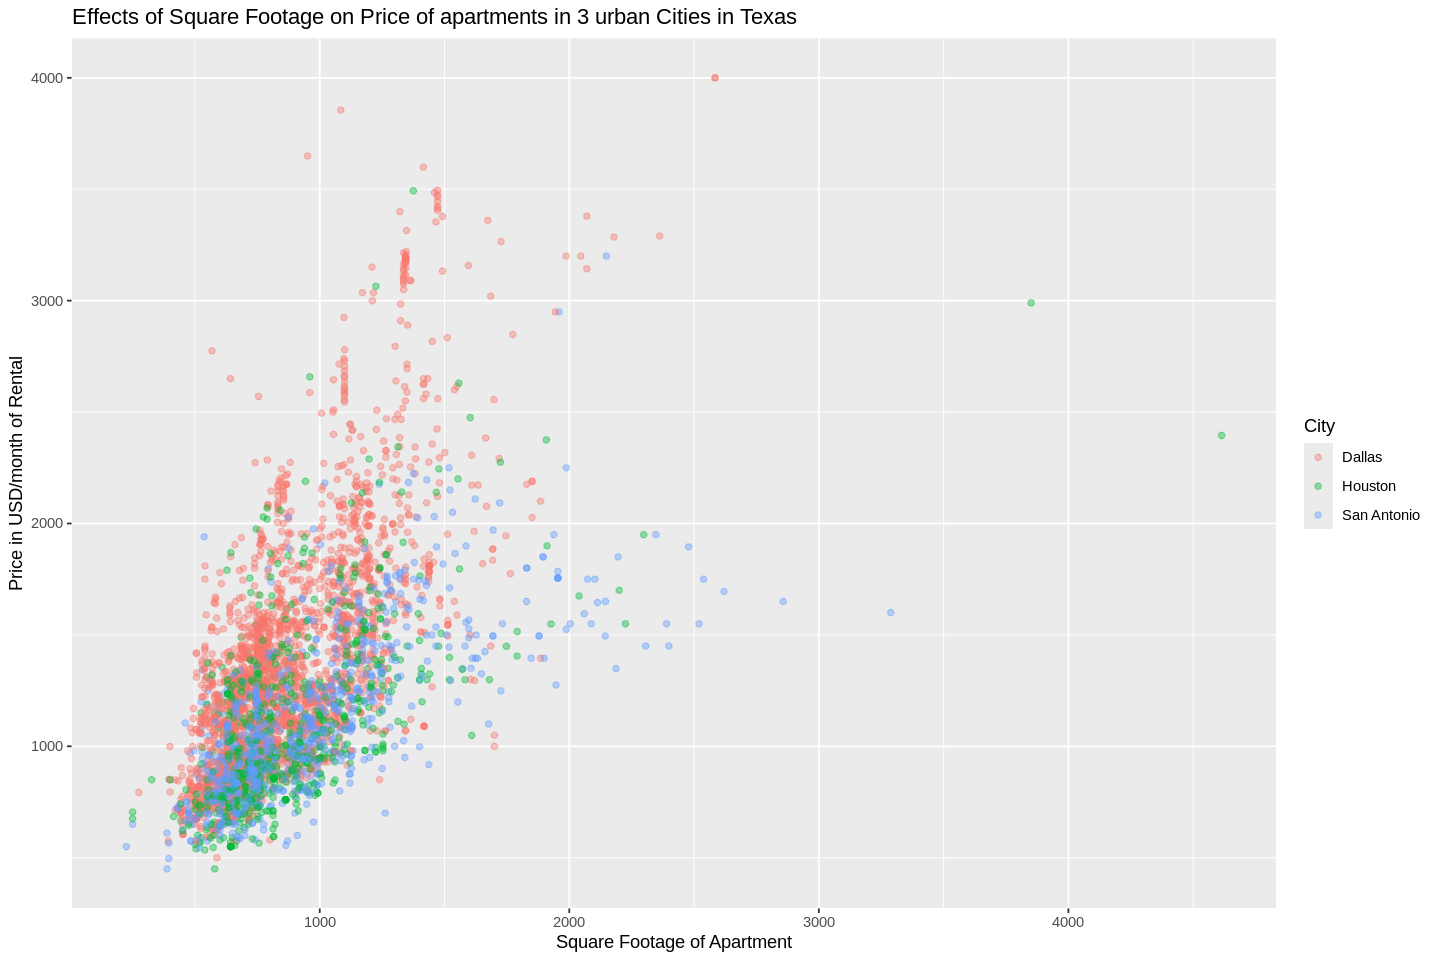

In [25]:
#The following code is use to create a scatter plot of the dataset "apt_texas_cities".
#This scatter plot will use as visualization for exploratory analysis to create some prediction before our actual analysis.

plot_texas_cities <- apt_texas_cities |>
    ggplot(aes (x = square_feet, y = price))+
    geom_point(alpha = 0.4, aes(color = cityname))+
    labs(x = "Square Footage of Apartment", y = "Price in USD/month of Rental", color = "City", 
            title = "Effects of Square Footage on Price of apartments in 3 urban Cities in Texas")
#Our code for plotting uses square feet on the x-axis and price on the y-axis as we are trying to see if the size of
#the apartment have any effect on the price.

plot_texas_cities

_Figure 6: A plot of Price vs Square Footage of the top 3 cities in Texas (Dallas, Houston, San Antonio)._

In [26]:
#The following code is to produce a brief summary table of the data that we will analyze. This is created mainly to compare face value of the 3 cities.
summary_table <- apt_texas_cities |>
  group_by(cityname) |>
  summarize(
    num_observations = n(),
    mean_bathrooms = mean(bathrooms),
    mean_bedrooms = mean(bedrooms),
    mean_square_feet = mean(square_feet, na.rm = TRUE),
    mean_price = mean(price, na.rm = TRUE))
  
summary_table

cityname,num_observations,mean_bathrooms,mean_bedrooms,mean_square_feet,mean_price
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Dallas,2798,1.363474,1.480343,870.2423,1340.039
Houston,739,1.302436,1.461434,869.0961,1091.018
San Antonio,873,1.430126,1.640321,936.6770,1111.101


_Figure 7: A summary table that contains the mean count of bathroom, bedrooms, and the mean price and square feet from our top 3 cities. The purpose is to have a quick look at the data that we are working with_

### Methods: Data Analysis

To compute our analysis - we will use linear regression. As we want to understand the trend and relationship between how square footage affect prices of rental. Linear regression is preferred in this scenario as through **Figure 6**, we notice that our points are very clustered and we can see a noticeable positive relationship. With this, linear regression is better to be intepret than normal regression.

To start - we will compute the linear regression for the top 3 cities in Texas as a whole to answer our first question.